In [1]:
# Cross Sectional Sector Momentum 전략 백테스트
# Monthly rebalancing 가정
# Winner/Loser Position, 투자 시작일(stDateNum)을 바꿔가며 Back-test 가능

# 현재 디렉토리 확인
import os
os.getcwd()

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
# ============================================================================
# Data 로딩 및 변수 정의
# ============================================================================
# 날짜 기준으로 오름차순 정렬된 Data 불러오기
data_excel = pd.ExcelFile('./Data/data_Sector_m.xlsx') # read_excel과 차이= 엑셀 시트 여러개를 한번에 가져옴
price_df = data_excel.parse(sheet_name = 'P_m', header=4) # Price Data d / w(Fri) / m(EoM)
total_df = data_excel.parse(sheet_name = 'TR_m', header=4) # Total Return Data d / w(Fri) / m(EoM)
rawTime = total_df.iloc[:, 0].copy()     # Date
rawMarket = total_df.iloc[:, 1].copy()   # Market Price (K200)
rawSector = total_df.iloc[:, 2:-1].copy()    # Scetor price 
rawRf = total_df.iloc[:, -1].copy()       # Risk-free rate (CD1m, %)
numRaw = len(rawTime)

# Sector HPR (based on TR Index, %)
rawRm = rawMarket.pct_change()*100 # (rawMarket / rawMarket.shift(1) - 1) * 100
rawRs = rawSector.pct_change()*100 # (rawSector / rawSector.shift(1) - 1) * 100
rawRf = rawRf.shift(1)/12 # CD1m의 정의를 고려하여 1칸 shift + 연율화 scaling

# Sector Momentum (based on Price Index, %)
MomHorizon = 12
rawMom = price_df.iloc[:,2:].pct_change(MomHorizon)*100
rawRanking = rawMom.rank(axis=1, ascending=False)
numSector = len(rawMom.columns)

In [4]:
# ============================================================================
# Back Test 시작시점 기준으로 데이터 정리 (이 작업을 원하지 않으면 엑셀을 편집)
# ============================================================================
stDateNum = 20021231  # 20021231  # Back Test 시작일 (투자 시작일)
stDate = pd.to_datetime(str(stDateNum), format='%Y%m%d')
idx = np.argmin(np.abs(rawTime - stDate))  # Back Test 시작일에 해당하는 index

Time = rawTime[idx:].copy().reset_index(drop = True)  # 깊은 복사, index 초기화
Rm = rawRm[idx:].copy().reset_index(drop = True)
Rs = rawRs[idx:].copy().reset_index(drop = True)
Rf = rawRf[idx:].copy().reset_index(drop = True)
Mom = rawMom[idx:].copy().reset_index(drop = True)
Ranking = rawRanking.iloc[idx:].copy().reset_index(drop = True)
numData = Time.shape[0]  # len(Data) or len(Data.index)

In [5]:
# ============================================================================
# Weight 
# ============================================================================
DecileSize = 0.1 # 원하는 Decile PF Size 설정
Winner = 1 # 롱포지션 유무 설정
Loser = 1 # 숏포지션 유무 설정

# Winner Loser 값에 따라 DecileSize 만큼의 자산 선택
if Winner == 1 :
    rawWinner = Ranking <= (DecileSize*numSector)
else : 
    rawWinner = pd.DataFrame(np.zeros([numData, numSector]),columns=rawMom.columns)

if Loser == 1 :
    rawLoser = Ranking > ((1-DecileSize)*numSector)
else : 
    rawLoser = pd.DataFrame(np.zeros([numData, numSector]),columns=rawMom.columns)

W1 = rawWinner*(numSector/DecileSize)/100
W2 = rawLoser*(numSector/DecileSize)/100

# WML
Wp = W1 - W2

In [6]:
# ============================================================================
# Portfolio Value
# ============================================================================
Rp = pd.Series(np.zeros(numData)) # 수익률 (단위: %)
Vp = pd.Series(np.zeros(numData)) # Value
Vp[0] = 100 # 투자원금 = 100

for t in range(1, numData) : 
    Rp.iloc[t] = Wp.iloc[t-1,:]@Rs.iloc[t,:]   # HPR 내적
    Vp.iloc[t] = Vp.iloc[t-1]*(1 + Rp.iloc[t]/100)   # Value

# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [7]:
# ============================================================================
# 벤치마크의 Value, DD 계산
# ============================================================================

# BM Value (투자 시작일 기준으로 표준화)
Vb = pd.Series(np.zeros(numData)) # Value
Vb[0] = 100 # 투자원금 = 100
# 포지션에 따라 BM이 다르기 때문에 조건문으로 처리
for t in range(1, numData) :
    if Loser == 0 :
        Vb[t] = Vb[t-1]*(1 + Rm[t]/100) # Market Return
    else : 
        Vb[t] = Vb[t-1]*(1 + (Rm[t]-Rf[t])/100) # Market Access Return

# BM DD
MAXb = Vb.cummax()
DDb = (Vb / MAXb - 1) * 100  # 단위: %

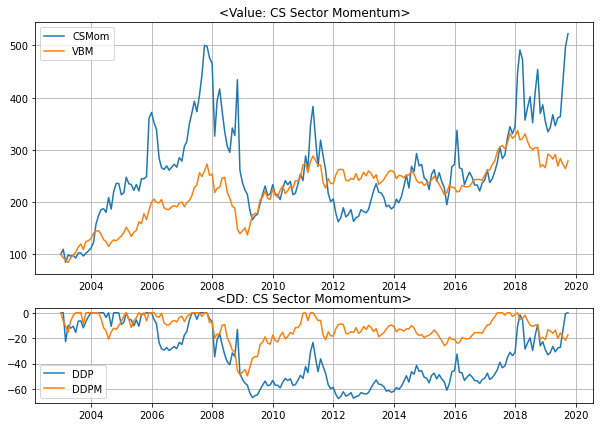

In [8]:
# ============================================================================
# 그래프 그리기
# ============================================================================

# Value와 MDD 그리기    
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3],
                       width_ratios=[5])    # subplot의 크기를 서로 다르게 설정

ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp, label = 'CSMom')
ax0.plot(Time, Vb, label = 'VBM')
ax0.set_title('<Value: CS Sector Momentum>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(Time, DDp, label = 'DDP')
ax1.plot(Time, DDb, label = 'DDPM')
ax1.set_title('<DD: CS Sector Momomentum>')
ax1.grid(True)
ax1.legend()

plt.show()